This is a slight modification of the example $PETSC_DIR/src/binding/petsc4py/demo/poisson2d/poisson2d.py
See also https://petsc.org/release/petsc4py/demo/poisson2d/poisson2d.html
Modifications: known exact solution, plot norms of residuals with matplotlib

Poisson in 2D
=============

Solve a constant coefficient Poisson problem on a regular grid. The source
code for this demo can be `downloaded here <../../_static/poisson2d.py>`__

.. math::

    - u_{xx} - u_{yy} = 1 \quad\textsf{in}\quad [0,1]^2\\
    u = 0 \quad\textsf{on the boundary.}

This is a naïve, parallel implementation, using :math:`n` interior grid
points per dimension and a lexicographic ordering of the nodes.

This code is kept as simple as possible. However, simplicity comes at a
price. Here we use a naive decomposition that does not lead to an optimal
communication complexity for the matrix-vector product. An optimal complexity
decomposition of a structured grid could be achieved using `PETSc.DMDA`.

This demo is structured as a script to be executed using:

.. code-block:: console

  $ python poisson2d.py

potentially with additional options passed at the end of the command.

In [1]:
import matplotlib.pyplot as plt

At the start of your script, call `petsc4py.init` passing `sys.argv` so that
command-line arguments to the script are passed through to PETSc.

In [2]:
import sys
import petsc4py

In [3]:
petsc4py.init(sys.argv)

The full PETSc4py API is to be found in the `petsc4py.PETSc` module.

In [4]:
from petsc4py import PETSc

PETSc is extensively programmable using the `PETSc.Options` database. For
more information see `working with PETSc Options <petsc_options>`.

In [5]:
OptDB = PETSc.Options()

Grid size and spacing using a default value of ``5``. The user can specify a
different number of points in each direction by passing the ``-n`` option to
the script.

In [6]:
n = OptDB.getInt('n', 5)
h = 1.0 / (n + 1)

Matrices are instances of the `PETSc.Mat` class.

In [7]:
A = PETSc.Mat()

Create the underlying PETSc C Mat object.
You can omit the ``comm`` argument if your objects live on
`PETSc.COMM_WORLD` but it is a dangerous choice to rely on default values
for such important arguments.

In [8]:
A.create(comm=PETSc.COMM_WORLD)

Specify global matrix shape with a tuple.

In [9]:
A.setSizes((n * n, n * n))

The call above implicitly assumes that we leave the parallel decomposition of
the matrix rows to PETSc by using `PETSc.DECIDE` for local sizes.
It is equivalent to:

.. code-block:: python

    A.setSizes(((PETSc.DECIDE, n * n), (PETSc.DECIDE, n * n)))

Here we use a sparse matrix of AIJ type
Various `matrix formats <petsc4py.PETSc.Mat.Type>` can be selected:

In [10]:
A.setType(PETSc.Mat.Type.AIJ)

Finally we allow the user to set any options they want to on the matrix from
the command line:

In [11]:
A.setFromOptions()

Insertion into some matrix types is vastly more efficient if we preallocate
space rather than allow this to happen dynamically. Here we hint the number
of nonzeros to be expected on each row.

In [12]:
A.setPreallocationNNZ(5)

We can now write out our finite difference matrix assembly using conventional
Python syntax. `Mat.getOwnershipRange` is used to retrieve the range of rows
local to this processor.

In [13]:
def index_to_grid(r):
    """Convert a row number into a grid point."""
    return (r // n, r % n)

In [14]:
rstart, rend = A.getOwnershipRange()
for row in range(rstart, rend):
    i, j = index_to_grid(row)
    A[row, row] = 4.0 / h**2
    if i > 0:
        column = row - n
        A[row, column] = -1.0 / h**2
    if i < n - 1:
        column = row + n
        A[row, column] = -1.0 / h**2
    if j > 0:
        column = row - 1
        A[row, column] = -1.0 / h**2
    if j < n - 1:
        column = row + 1
        A[row, column] = -1.0 / h**2

At this stage, any exchange of information required in the matrix assembly
process has not occurred. We achieve this by calling `Mat.assemblyBegin` and
then `Mat.assemblyEnd`.

In [15]:
A.assemblyBegin()
A.assemblyEnd()

We set up an additional option so that the user can print the matrix by
passing ``-view_mat`` to the script.

In [16]:
A.viewFromOptions('-view_mat')

PETSc represents all linear solvers as preconditioned Krylov subspace methods
of type `PETSc.KSP`. Here we create a KSP object for a conjugate gradient
solver preconditioned with an algebraic multigrid method.

In [17]:
ksp = PETSc.KSP()
ksp.create(comm=A.getComm())
ksp.setType(PETSc.KSP.Type.CG)
ksp.getPC().setType(PETSc.PC.Type.GAMG)

We set the matrix in our linear solver and allow the user to program the
solver with options.

In [18]:
ksp.setOperators(A)
ksp.setFromOptions()

Since the matrix knows its size and parallel distribution, we can retrieve
appropriately-scaled vectors using `Mat.createVecs`. PETSc vectors are
objects of type `PETSc.Vec`. Here we set the right-hand side of our system to
a vector of ones, and then solve.

In [19]:
x, b = A.createVecs()
x.set(1.0)
A.mult(x, b)
ksp.setConvergenceHistory()
ksp.solve(b, x)

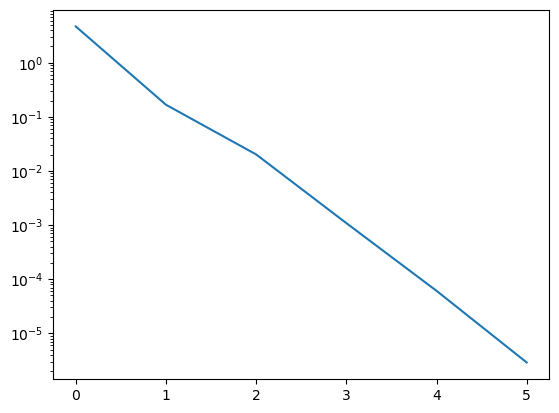

In [20]:
# plot norms of residuals
res = ksp.getConvergenceHistory()
if (PETSc.COMM_WORLD.rank == 0):
    plt.semilogy(res)
    plt.show()
    #plt.savefig("residual.png")

Finally, allow the user to print the solution by passing ``-view_sol`` to the
script.

In [21]:
x.viewFromOptions('-view_sol')

TODO Things to try
-------------

- Show the solution with ``-view_sol``.
- Show the matrix with ``-view_mat``.
- Monitor convergence with ``-ksp_monitor``.
- Change the resolution with ``-n``.
- Use a direct solver by passing ``-ksp_type preonly -pc_type lu``.
- View solver and its settings with ``-ksp_view``.
- Change tolerance with ``-ksp_rtol``.
- Change solvers with ``-ksp_type`` and preconditioners with ``-pc_type``. Monitor convergence.
- Run in parallel on two processors using:

  .. code-block:: console

      mpiexec -n 2 python poisson2d.py